In [1]:
import pandas as pd
import numpy as np
import os
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams['font.family'] = 'Malgun Gothic'
import datetime

In [2]:
date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')

In [3]:
date_today_record = str(date_today).split(' ')[0].replace('-', '')
date_today_record

'20210604'

In [4]:
def day_modifier(x):
    # x is a number
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x)
        if len(x) == 1:
            return '0' + x
        else:
            return x

In [5]:
def landnum_modifier(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x).replace('외', '').replace(' ','')
        splitted = x.split('-')
        if len(splitted) == 1:
            return x + '-0'
        else:
            return x

In [6]:
def data_prep(bdtype, tradetype):
    # bdtype is a string: one of 아파트, 연립다세대 or 오피스텔
    # tradetype is a string: one of 매매 or 전월세
    
    basedir = './국토교통부_실거래가_공개시스템/{}/{}/'.format(bdtype, tradetype)
    filenames = [f for f in os.listdir(basedir) if (f.endswith('.csv'))&('(' in f)]
    
    dfs_list = []
    for i, f in tqdm(enumerate(filenames)):
        df = pd.read_csv(basedir + f, encoding='euc-kr', header=15)
        if '해제사유발생일' in df.columns.tolist():
            df = df[df['해제사유발생일'].isna()]
            df = df.drop(columns=['해제사유발생일'])

        dfs_list.append(df)
    
    concat_df = pd.concat(dfs_list).reset_index(drop=True)
        
    concat_df['번지'] = concat_df['번지'].apply(landnum_modifier)
    
    concat_df['계약년월'] = concat_df['계약년월'].apply(str)
    concat_df['계약일'] = concat_df['계약일'].apply(str)
    
    concat_df['계약날짜기준_건물연식'] = concat_df['계약년월'].apply(lambda x: int(x[:4])) - concat_df['건축년도']
    
    concat_df['계약일'] = concat_df['계약일'].apply(day_modifier)
    
    concat_df['계약날짜'] = concat_df['계약년월'].apply(lambda x: x[:4]) + '-' + concat_df['계약년월'].apply(lambda x: x[-2:])\
    + '-' + concat_df['계약일']
    
    concat_df['계약날짜'] = pd.to_datetime(concat_df['계약날짜'], format='%Y-%m-%d')
    
    concat_df['거래금액(만원)'] = concat_df['거래금액(만원)'].apply(lambda x: int(x.replace(',','')))
    concat_df['단가(만원/㎡)'] = concat_df['거래금액(만원)'] / concat_df['전용면적(㎡)']
    
    concat_df['지번주소'] = concat_df['시군구'] + ' ' + concat_df['번지']
        
    cols_to_drop = ['시군구', '번지', '본번', '부번', '지번주소', '계약년월', '계약일', '도로명']
        
    concat_df = concat_df[['지번주소', '도로명'] + [col for col in concat_df.columns if col not in cols_to_drop]]
    
    date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')
    concat_df['건물연식'] = date_today.year - concat_df['건축년도']
    
    concat_df = concat_df.dropna(subset=['지번주소'])
    
    if '건물명' in concat_df.columns:
        concat_df.rename(columns={'건물명':'건물(단지)명'}, inplace=True)
    elif '단지명' in concat_df.columns:
        concat_df.rename(columns={'단지명':'건물(단지)명'}, inplace=True)
    
    concat_df = concat_df[concat_df['층'] >= 0].reset_index(drop=True)
    
    return concat_df

In [7]:
target_house = '연립다세대'
house_df = data_prep(target_house, '매매')
house_df['부동산유형'] = target_house
print(house_df.shape)
house_df.head()

16it [00:01,  9.25it/s]


(635814, 13)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형
0,서울특별시 강남구 개포동 171-13,선릉로14길 11,(171-13),68.08,56.10,56500,2,1988.0,18.0,2006-12-20,829.905993,33.0,연립다세대
1,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,40500,2,1988.0,18.0,2006-12-09,770.108386,33.0,연립다세대
2,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,42000,1,1988.0,18.0,2006-12-19,798.630918,33.0,연립다세대
3,서울특별시 강남구 개포동 1239-6,개포로15길 27,강남빌라 나동,52.75,44.68,22000,2,1988.0,18.0,2006-11-02,417.061611,33.0,연립다세대
4,서울특별시 강남구 개포동 1175-2,논현로6길 36-8,강남파크,49.43,23.70,17000,4,1993.0,13.0,2006-07-19,343.920696,28.0,연립다세대


In [8]:
land_specs_df = pd.read_csv('./prepped_data/land_specs_ver_4.csv')
print(land_specs_df.shape)
land_specs_df.head()

(8706295, 11)


,지번주소,년,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,공시지가
0,서울특별시 강남구 개포동 100-0,2013,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,325000.0
1,서울특별시 강남구 개포동 100-0,2014,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,330000.0
2,서울특별시 강남구 개포동 100-0,2015,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,335000.0
3,서울특별시 강남구 개포동 100-0,2016,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,345000.0
4,서울특별시 강남구 개포동 100-0,2017,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,355000.0


In [9]:
last_df = land_specs_df.drop_duplicates(subset=['지번주소'], keep='last').drop(columns=['년', '공시지가']).reset_index(drop=True)
print(last_df.shape)
last_df.head()

(981464, 9)


,지번주소,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면
0,서울특별시 강남구 개포동 100-0,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지
1,서울특별시 강남구 개포동 101-0,전,641.0,자연녹지지역,지정되지않음,전,평지,부정형,맹지
2,서울특별시 강남구 개포동 102-0,전,509.0,자연녹지지역,지정되지않음,전,평지,부정형,맹지
3,서울특별시 강남구 개포동 103-0,전,48.7,자연녹지지역,개발제한구역,전,평지,부정형,맹지
4,서울특별시 강남구 개포동 104-1,전,2995.0,개발제한구역,자연녹지지역,전,완경사,부정형,맹지


In [10]:
house_merge_df = house_df.merge(last_df, on=['지번주소']).reset_index(drop=True)
print(house_merge_df.shape)

(633250, 21)


In [11]:
house_df['구'] = house_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_df['동'] = house_df['지번주소'].apply(lambda x: x.split(' ')[2])
house_merge_df['구'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_merge_df['동'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[2])

In [12]:
target_gu = '중구'
target_dong = '신당동'
target_purpose = '준주거'
target_building_age = 5
target_period = 36 # in months

In [13]:
target_df = house_merge_df[
    (house_merge_df['구'] == target_gu)
    &(house_merge_df['동'] == target_dong)
    &(house_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_period)))
    &(house_merge_df['건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df.shape)
target_df.head()

(142, 23)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동
591830,서울특별시 중구 신당동 333-66,다산로24길 14,(333-66),25.52,12.93,29500,7,2017.0,1.0,2018-09-05,1155.956113,4.0,연립다세대,대,396.0,제3종일반주거지역,지정되지않음,주상용,평지,가로장방,세로한면(가),중구,신당동
591831,서울특별시 중구 신당동 333-66,다산로24길 14,(333-66),29.96,15.18,35000,7,2017.0,2.0,2019-12-12,1168.224299,4.0,연립다세대,대,396.0,제3종일반주거지역,지정되지않음,주상용,평지,가로장방,세로한면(가),중구,신당동
591832,서울특별시 중구 신당동 333-66,다산로24길 14,(333-66),29.96,14.51,32100,6,2017.0,3.0,2020-10-15,1071.428571,4.0,연립다세대,대,396.0,제3종일반주거지역,지정되지않음,주상용,평지,가로장방,세로한면(가),중구,신당동
591841,서울특별시 중구 신당동 346-452,동호로8가길 43,(346-452),22.77,29.85,30000,4,2017.0,1.0,2018-07-02,1317.523057,4.0,연립다세대,대,248.0,제2종일반주거지역,지정되지않음,주거기타,완경사,세로장방,세로한면(가),중구,신당동
591842,서울특별시 중구 신당동 346-452,동호로8가길 43,(346-452),28.01,30.14,30700,4,2017.0,1.0,2018-12-17,1096.037130,4.0,연립다세대,대,248.0,제2종일반주거지역,지정되지않음,주거기타,완경사,세로장방,세로한면(가),중구,신당동


In [14]:
sales_idx_basedir = './한국부동산원/실거래가격지수/'
filenames = [f for f in os.listdir(sales_idx_basedir) if '연립다세대' in f]

sales_idx_df = pd.read_excel(sales_idx_basedir + filenames[0], header=[10, 11])

sales_idx_cols_list = []
for i in range(sales_idx_df.shape[1]):
    if i == 0:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0])
    else:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0] + '_' + sales_idx_df.columns[i][1])

sales_idx_df.columns = sales_idx_cols_list

In [15]:
def get_sales_idx(x):
    # x is a pandas timestamp
    
    df = sales_idx_df.copy()
    
    if pd.isna(x) == True:
        return x
    else:
        year = str(x.year)
        month = str(x.month)
        if len(month) == 1:
            month = '0'+month
        
        idx = df[year+'년 '+month+'월_지수'].iloc[0]
        
        return idx

In [16]:
def get_index_applied_prices(df):
    df = df.copy()
    
    last_idx = sales_idx_df.iloc[0,-2]
    
    last_date = sales_idx_df.columns[-1].split('_')[0]
    
    last_date = last_date.split(' ')[0].replace('년','') + '-' + last_date.split(' ')[1].replace('월','') + '-01'
    
    target_upper_limit_df = df[df['계약날짜'] < pd.to_datetime(last_date)]
    target_upper_limit_df['계약날짜_실거래지수'] = target_upper_limit_df['계약날짜'].apply(get_sales_idx)
    target_upper_limit_df['지수적용단가'] = target_upper_limit_df['단가(만원/㎡)'] / target_upper_limit_df['계약날짜_실거래지수'] * last_idx
    df['지수적용단가'] = df['단가(만원/㎡)']
    df.loc[target_upper_limit_df.index, '지수적용단가'] = target_upper_limit_df['지수적용단가']
    df['평가날짜'] = df['계약날짜']
    df.loc[target_upper_limit_df.index, '평가날짜'] = pd.to_datetime(last_date[:-2] + '01')
    
    return df

In [17]:
target_df = get_index_applied_prices(target_df)
print(target_df.shape)
target_df.head()

(142, 25)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동,지수적용단가,평가날짜
591830,서울특별시 중구 신당동 333-66,다산로24길 14,(333-66),25.52,12.93,29500,7,2017.0,1.0,2018-09-05,1155.956113,4.0,연립다세대,대,396.0,제3종일반주거지역,지정되지않음,주상용,평지,가로장방,세로한면(가),중구,신당동,1362.820905,2021-03-01
591831,서울특별시 중구 신당동 333-66,다산로24길 14,(333-66),29.96,15.18,35000,7,2017.0,2.0,2019-12-12,1168.224299,4.0,연립다세대,대,396.0,제3종일반주거지역,지정되지않음,주상용,평지,가로장방,세로한면(가),중구,신당동,1326.253248,2021-03-01
591832,서울특별시 중구 신당동 333-66,다산로24길 14,(333-66),29.96,14.51,32100,6,2017.0,3.0,2020-10-15,1071.428571,4.0,연립다세대,대,396.0,제3종일반주거지역,지정되지않음,주상용,평지,가로장방,세로한면(가),중구,신당동,1129.647721,2021-03-01
591841,서울특별시 중구 신당동 346-452,동호로8가길 43,(346-452),22.77,29.85,30000,4,2017.0,1.0,2018-07-02,1317.523057,4.0,연립다세대,대,248.0,제2종일반주거지역,지정되지않음,주거기타,완경사,세로장방,세로한면(가),중구,신당동,1585.456805,2021-03-01
591842,서울특별시 중구 신당동 346-452,동호로8가길 43,(346-452),28.01,30.14,30700,4,2017.0,1.0,2018-12-17,1096.037130,4.0,연립다세대,대,248.0,제2종일반주거지역,지정되지않음,주거기타,완경사,세로장방,세로한면(가),중구,신당동,1314.429720,2021-03-01


In [18]:
target_df = target_df.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
target_df1 = target_df[['지번주소', '건물(단지)명', '건물연식', '전용면적(㎡)', '계약날짜', '거래금액(만원)', '단가(만원/㎡)', '평가날짜', '지수적용단가', '용도지역명1', '부동산유형']]
target_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)

In [19]:
target_df1.head()

,지번주소,건물(단지)명,건물연식,전용면적(㎡),계약날짜,거래금액(만원),단가(만원/㎡),평가날짜,지수적용단가,용도지역명1,부동산유형
0,서울특별시 중구 신당동 155-14,골드캐슬,5.0,29.96,2020-01-02,28800,961.281709,2021-03-01,1096.913303,제2종일반주거지역,연립다세대
1,서울특별시 중구 신당동 155-14,골드캐슬,5.0,29.96,2020-06-27,32900,1098.130841,2021-03-01,1195.161984,제2종일반주거지역,연립다세대
2,서울특별시 중구 신당동 155-14,골드캐슬,5.0,29.98,2021-03-29,30700,1024.016011,2021-03-29,1024.016011,제2종일반주거지역,연립다세대
3,서울특별시 중구 신당동 155-14,골드캐슬,5.0,29.35,2021-05-05,33000,1124.361158,2021-05-05,1124.361158,제2종일반주거지역,연립다세대
4,서울특별시 중구 신당동 155-14,골드캐슬,5.0,29.77,2021-05-11,30700,1031.239503,2021-05-11,1031.239503,제2종일반주거지역,연립다세대


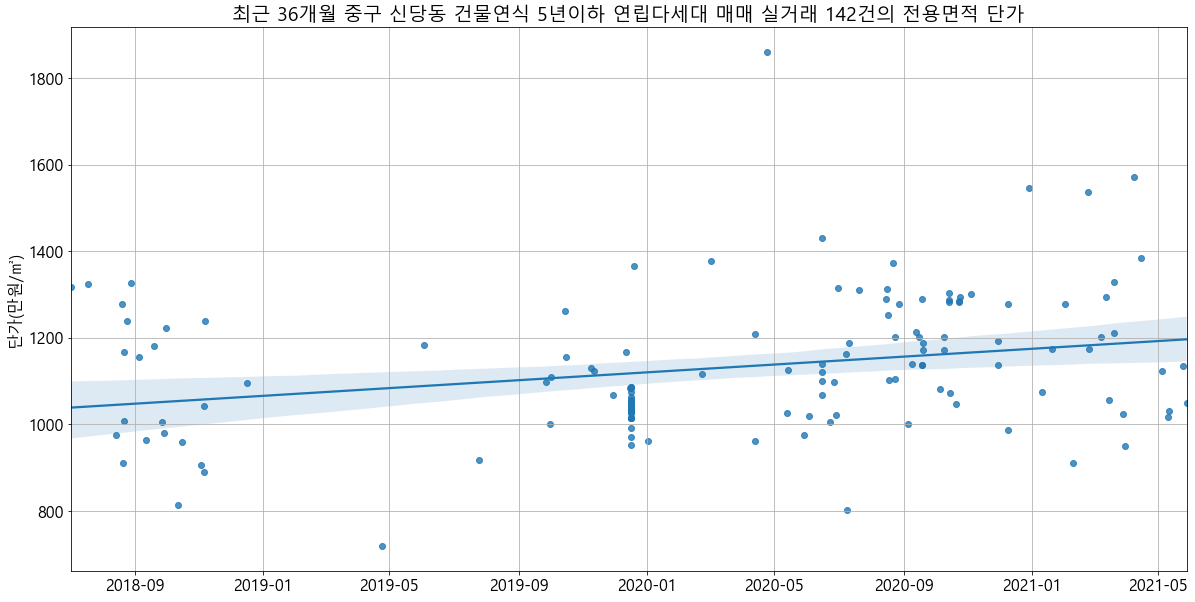

In [20]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 {} 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_house, target_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_df['계약날짜']), y=target_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/산포도.png'.format(target_gu, target_dong, target_house, date_today_record))

In [21]:
target_last_df = target_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last').reset_index(drop=True)

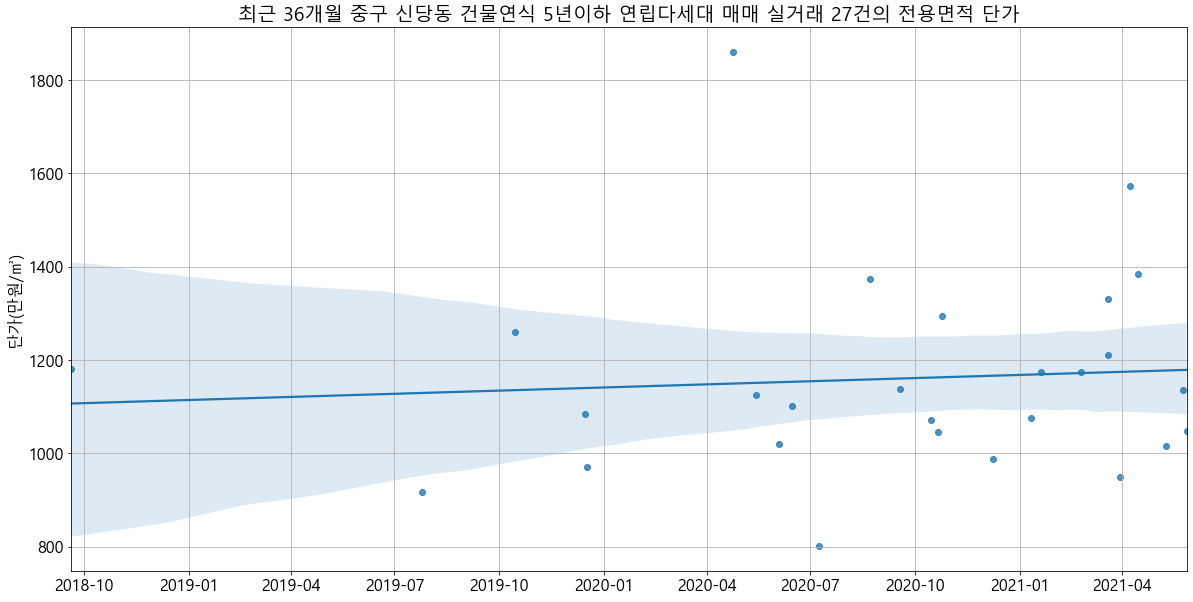

In [22]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 {} 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_house, target_last_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_last_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_last_df['계약날짜']), y=target_last_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/마지막_산포도.png'.format(target_gu, target_dong, target_house, date_today_record))

In [23]:
target_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/마지막_실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)

In [24]:
target_df2 = house_merge_df[
    (house_merge_df['구'] == target_gu)
    &(house_merge_df['동'] == target_dong)
    #&(house_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_period)))
    &(house_merge_df['계약날짜기준_건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df2.shape)
target_df2.head()

(776, 23)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동
266536,서울특별시 중구 신당동 166-27,퇴계로88가길 52-8,(166-27),71.85,39.06,15000,4,2005.0,1.0,2006-03-26,208.768267,16.0,연립다세대,대,277.2,제2종일반주거지역,지정되지않음,다세대,평지,가로장방,소로한면,중구,신당동
266537,서울특별시 중구 신당동 166-27,퇴계로88가길 52-8,(166-27),62.97,34.23,15500,4,2005.0,1.0,2006-04-11,246.148960,16.0,연립다세대,대,277.2,제2종일반주거지역,지정되지않음,다세대,평지,가로장방,소로한면,중구,신당동
266538,서울특별시 중구 신당동 166-27,퇴계로88가길 52-8,(166-27),77.19,41.95,15000,1,2005.0,1.0,2006-04-27,194.325690,16.0,연립다세대,대,277.2,제2종일반주거지역,지정되지않음,다세대,평지,가로장방,소로한면,중구,신당동
266539,서울특별시 중구 신당동 166-27,퇴계로88가길 52-8,(166-27),62.97,34.23,28500,4,2005.0,5.0,2010-07-20,452.596475,16.0,연립다세대,대,277.2,제2종일반주거지역,지정되지않음,다세대,평지,가로장방,소로한면,중구,신당동
266584,서울특별시 중구 신당동 431-17,동호로15길 21-10,(431-17),63.75,28.89,14000,4,2002.0,4.0,2006-11-16,219.607843,19.0,연립다세대,대,310.0,준주거지역,지정되지않음,주상용,평지,사다리형,세로한면(가),중구,신당동


In [25]:
target_df2 = get_index_applied_prices(target_df2)

<AxesSubplot:title={'center':'중구 신당동 계약날짜기준 건물연식 5년이하 연립다세대 매매 실거래 776건의 전용면적 단가'}, xlabel='단가(만원/㎡)', ylabel='Count'>

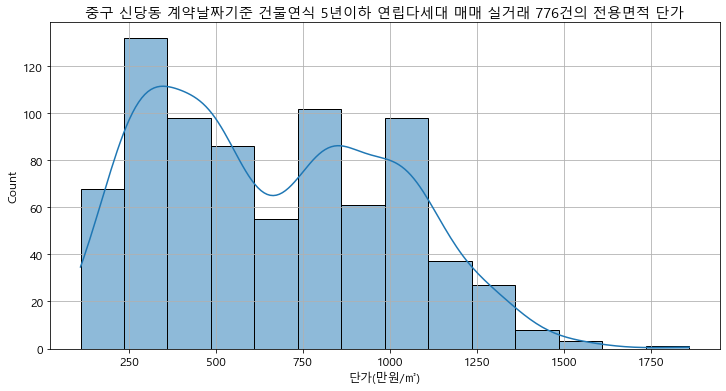

In [26]:
font = {'size': 12}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(12,6))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 {} 매매 실거래 {}건의 전용면적 단가'.format(target_gu, target_dong, target_building_age, target_house, target_df2.shape[0]))
plt.grid(True)
sns.histplot(target_df2['단가(만원/㎡)'], kde=True)

In [27]:
target_df3 = target_df2[['지번주소', '건물(단지)명', '건축년도', '전용면적(㎡)', '계약날짜', '단가(만원/㎡)', '평가날짜', '지수적용단가', '용도지역명1', '부동산유형']]
target_df3 = target_df3.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
target_df3.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/지수적용_실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)

In [28]:
concat_df = pd.concat([target_df2])

In [29]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '전용면적(㎡)', '계약날짜']).reset_index(drop=True)
concat_df = concat_df.drop_duplicates(['지번주소', '건축년도', '전용면적(㎡)'], keep='last').reset_index(drop=True)

In [30]:
concat_df['단가평균'] = concat_df[['지번주소', '건축년도', '단가(만원/㎡)']].groupby(['지번주소', '건축년도']).transform('mean')['단가(만원/㎡)']
concat_df['지수적용단가평균'] = concat_df[['지번주소', '건축년도', '지수적용단가']].groupby(['지번주소', '건축년도']).transform('mean')['지수적용단가']

In [31]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '평가날짜']).reset_index(drop=True)
print(concat_df.shape)
concat_df.head()

(445, 27)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동,지수적용단가,평가날짜,단가평균,지수적용단가평균
0,서울특별시 중구 신당동 133-24,다산로42다길 13,리버그린,70.80,38.80,33000,5,2008.0,0.0,2008-09-26,466.101695,13.0,연립다세대,대,310.4,제2종일반주거지역,지정되지않음,주상기타,평지,사다리형,세로한면(가),중구,신당동,616.327178,2021-03-01,466.101695,616.327178
1,서울특별시 중구 신당동 151-19,퇴계로88길 17-11,한영그린빌,28.74,17.08,21000,3,2014.0,3.0,2017-03-10,730.688935,7.0,연립다세대,대,161.6,제2종일반주거지역,지정되지않음,주상기타,평지,정방형,세로한면(가),중구,신당동,948.964051,2021-03-01,672.389888,875.491618
2,서울특별시 중구 신당동 151-19,퇴계로88길 17-11,한영그린빌,52.39,31.15,33800,3,2014.0,3.0,2017-04-19,645.161290,7.0,연립다세대,대,161.6,제2종일반주거지역,지정되지않음,주상기타,평지,정방형,세로한면(가),중구,신당동,833.668514,2021-03-01,672.389888,875.491618
3,서울특별시 중구 신당동 151-19,퇴계로88길 17-11,한영그린빌,52.71,31.33,38000,4,2014.0,4.0,2018-08-23,720.925821,7.0,연립다세대,대,161.6,제2종일반주거지역,지정되지않음,주상기타,평지,정방형,세로한면(가),중구,신당동,857.503520,2021-03-01,672.389888,875.491618
4,서울특별시 중구 신당동 151-19,퇴계로88길 17-11,한영그린빌,54.32,32.30,32200,2,2014.0,0.0,2014-10-15,592.783505,7.0,연립다세대,대,161.6,제2종일반주거지역,지정되지않음,주상기타,평지,정방형,세로한면(가),중구,신당동,861.830387,2021-03-01,672.389888,875.491618


In [32]:
concat_last_df = concat_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last')
print(concat_last_df.shape)
concat_last_df

(159, 27)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동,지수적용단가,평가날짜,단가평균,지수적용단가평균
0,서울특별시 중구 신당동 133-24,다산로42다길 13,리버그린,70.800,38.80,33000,5,2008.0,0.0,2008-09-26,466.101695,13.0,연립다세대,대,310.4,제2종일반주거지역,지정되지않음,주상기타,평지,사다리형,세로한면(가),중구,신당동,616.327178,2021-03-01,466.101695,616.327178
4,서울특별시 중구 신당동 151-19,퇴계로88길 17-11,한영그린빌,54.320,32.30,32200,2,2014.0,0.0,2014-10-15,592.783505,7.0,연립다세대,대,161.6,제2종일반주거지역,지정되지않음,주상기타,평지,정방형,세로한면(가),중구,신당동,861.830387,2021-03-01,672.389888,875.491618
7,서울특별시 중구 신당동 154-46,다산로42길 99,신당코지2차,16.330,11.42,12600,3,2013.0,4.0,2017-11-22,771.586038,8.0,연립다세대,대,244.1,제2종일반주거지역,지정되지않음,주상용,평지,세로장방,소로한면,중구,신당동,968.348194,2021-03-01,850.782180,1056.050291
11,서울특별시 중구 신당동 155-14,퇴계로88가길 15,골드캐슬,29.960,19.30,34000,5,2016.0,5.0,2021-05-25,1134.846462,5.0,연립다세대,대,249.4,제2종일반주거지역,지정되지않음,주상기타,평지,세로장방,소로한면,중구,신당동,1134.846462,2021-05-25,1078.615783,1078.615783
12,서울특별시 중구 신당동 165-43,퇴계로90길 59-7,윤원팰리스,40.830,26.00,41500,4,2021.0,0.0,2021-05-10,1016.409503,0.0,연립다세대,대,234.4,제2종일반주거지역,지정되지않음,단독,평지,정방형,세로한면(불),중구,신당동,1016.409503,2021-05-10,1016.409503,1016.409503
14,서울특별시 중구 신당동 166-1,퇴계로88가길 52,푸른마을,79.440,37.05,25000,4,2003.0,4.0,2007-05-11,314.702920,18.0,연립다세대,대,329.3,제2종일반주거지역,지정되지않음,주상기타,평지,사다리형,세로각지(가),중구,신당동,553.786946,2021-03-01,380.408516,636.744405
17,서울특별시 중구 신당동 166-27,퇴계로88가길 52-8,(166-27),77.190,41.95,15000,1,2005.0,1.0,2006-04-27,194.325690,16.0,연립다세대,대,277.2,제2종일반주거지역,지정되지않음,다세대,평지,가로장방,소로한면,중구,신당동,459.562607,2021-03-01,285.230144,527.939578
20,서울특별시 중구 신당동 236-258,다산로33길 85,젬스톤빌리지,29.030,21.79,34300,5,2018.0,0.0,2018-09-19,1181.536342,3.0,연립다세대,대,435.0,제2종일반주거지역,지정되지않음,상업기타,평지,사다리형,소로한면,중구,신당동,1392.978858,2021-03-01,1209.111171,1434.042182
25,서울특별시 중구 신당동 236-43,다산로31길 38-5,(236-43),34.530,25.60,33200,4,2008.0,3.0,2011-08-26,961.482769,13.0,연립다세대,대,176.0,제2종일반주거지역,지정되지않음,다세대,평지,정방형,세로한면(가),중구,신당동,1323.553499,2021-03-01,1104.566021,1511.580529
29,서울특별시 중구 신당동 236-44,다산로31길 38-3,(236-44),36.360,26.50,33000,2,2008.0,2.0,2010-06-22,907.590759,13.0,연립다세대,대,175.0,제2종일반주거지역,지정되지않음,다세대,평지,정방형,세로한면(가),중구,신당동,1229.037926,2021-03-01,1094.352483,1461.725667


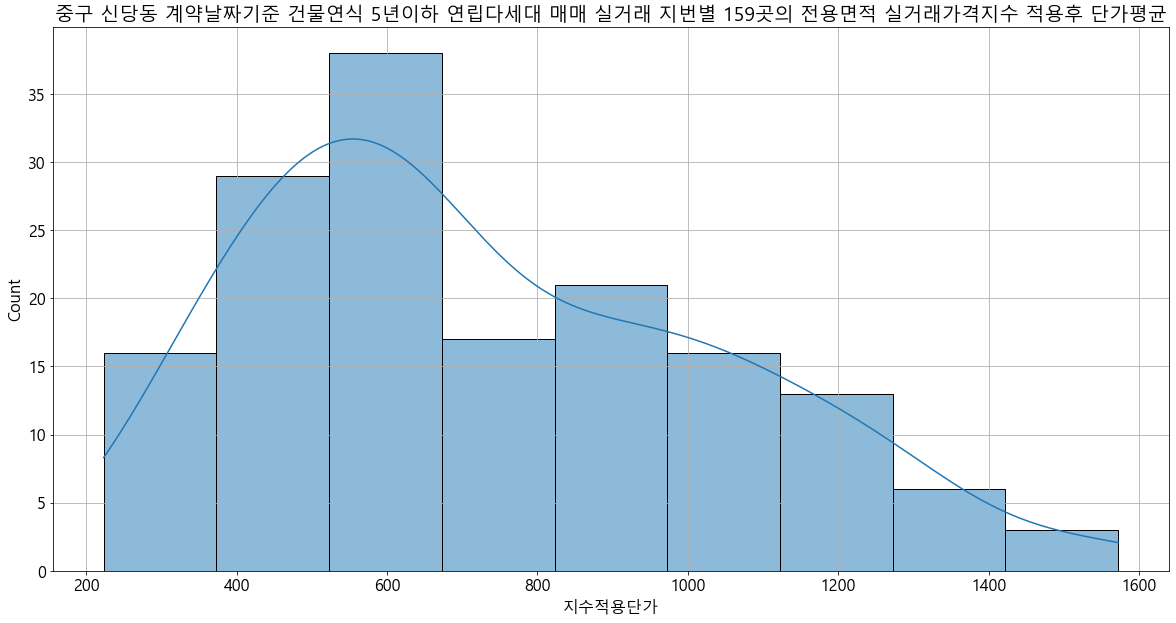

In [33]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 {} 매매 실거래 지번별 {}곳의 전용면적 실거래가격지수 적용후 단가평균'.format(target_gu, target_dong, target_building_age, target_house, concat_last_df.shape[0]))
plt.grid(True)
sns.histplot(concat_last_df['지수적용단가'], kde=True)
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/지번별_분포도.png'.format(target_gu, target_dong, target_house, date_today_record))

In [34]:
concat_last_df = concat_last_df.sort_values(['지번주소']).reset_index(drop=True)

In [35]:
concat_last_df = concat_last_df[['지번주소', '건물(단지)명', '건축년도', '전용면적(㎡)', '계약날짜', '단가(만원/㎡)', '평가날짜', '지수적용단가', '용도지역명1', '부동산유형']]
concat_last_df.rename(columns={'계약날짜':'마지막_계약날짜'}, inplace=True)
concat_last_df.head()

,지번주소,건물(단지)명,건축년도,전용면적(㎡),마지막_계약날짜,단가(만원/㎡),평가날짜,지수적용단가,용도지역명1,부동산유형
0,서울특별시 중구 신당동 133-24,리버그린,2008.0,70.80,2008-09-26,466.101695,2021-03-01,616.327178,제2종일반주거지역,연립다세대
1,서울특별시 중구 신당동 151-19,한영그린빌,2014.0,54.32,2014-10-15,592.783505,2021-03-01,861.830387,제2종일반주거지역,연립다세대
2,서울특별시 중구 신당동 154-46,신당코지2차,2013.0,16.33,2017-11-22,771.586038,2021-03-01,968.348194,제2종일반주거지역,연립다세대
3,서울특별시 중구 신당동 155-14,골드캐슬,2016.0,29.96,2021-05-25,1134.846462,2021-05-25,1134.846462,제2종일반주거지역,연립다세대
4,서울특별시 중구 신당동 165-43,윤원팰리스,2021.0,40.83,2021-05-10,1016.409503,2021-05-10,1016.409503,제2종일반주거지역,연립다세대


In [36]:
concat_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/지수적용_마지막_실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)